In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.collections import LineCollection

import multiprocessing
import functools

from scipy import stats

In [2]:
## generate random Poisson spots

def hotspots(Lx,Ly,N,seed=None):
    rng = np.random.default_rng(seed)
    xs = rng.random(N)*Lx
    ys = rng.random(N)*Ly
    return np.vstack((xs,ys)).T


class HotspotObject:
    def __init__(self,lx,ly,n,seed=None,step=2,lcut=0):
        self.lx = lx
        self.ly = ly
        self.n = n
        
        # correction when l < 2R
        self.lcut = lcut
        
        # create frozen random hotspots
        self.hs = hotspots(lx,ly,n,seed) 
        
        # add bottom and top rows
        botrow = [(i,0) for i in range(0,lx,step)]
        toprow = [(i,ly) for i in range(0,lx,step)]
        
        rown = len(botrow)
        
        self.hs = np.vstack((self.hs,botrow,toprow))
        self.botidx = np.arange(n,n+rown)
        self.topidx = np.arange(n+rown,n+2*rown)
        
        # fully connected graph
        self.G = nx.complete_graph(len(self.hs))
        
        self.axes = None
        
        
    def edgedistance(self,i,j):
        return np.linalg.norm(self.hs[i]-self.hs[j])
        
    def shortest_path(self,delta,source,target):
        '''Calculate the shortest path with edge weights 
        that subtract a fixed amount delta from the node-to-node length'''
        
        weightfn = lambda i,j,dummy: max(self.edgedistance(i,j)*self.lcut,self.edgedistance(i,j)-delta) # avoid negative edge weights
        return nx.shortest_path(self.G,source=source,target=target,weight=weightfn)
    
    def shortest_path_length(self,delta,source,target):
        '''Calculate the shortest path with edge weights 
        that subtract a fixed amount delta from the node-to-node length'''
        
        weightfn = lambda i,j,dummy: max(self.edgedistance(i,j)*self.lcut,self.edgedistance(i,j)-delta) # avoid negative edge weights
        return nx.shortest_path_length(self.G,source=source,target=target,weight=weightfn)
    
    def shortest_paths_floydwarshall(self,delta):
        '''Find all shortest paths with floyds algorithm'''
        
        # calculate all path weights
        for i,j in self.G.edges:
            
            # task: add actual distances between nodes
            self.G[i][j]['weight'] = max(self.edgedistance(i,j)*self.lcut,self.edgedistance(i,j)-delta)
        
        # create distance array
        return nx.floyd_warshall_numpy(self.G)
    
    def trees(self,delta,topnodes=None):
        '''trace all trees from a set of given nodes to all bottom nodes.
        if no topnodes are given, run all trees from all topnodes'''
        if topnodes is None:
            topnodes = self.topidx
            
        allpathdists = self.shortest_paths_floydwarshall(delta)
        
        results = []
        
        for i in topnodes:
            rootidx = self.botidx[np.argmin(allpathdists[i,self.botidx])]
            results.append((self.shortest_path(delta,i,rootidx)))
        
        return results
    
    def get_axes(self):
        '''convenience function to plot multiple things on same axis'''
        if self.axes is None:
            plt.figure()
            self.axes = plt.gca()
        return self.axes
    
    def plotpoints(self,axes=None,color='0.5'):
        '''scatter of all hotspots'''
        if axes is None:                 
            axes = self.get_axes()

        axes.scatter(*self.hs.T,color=color)
        
    
    def plottree(self,tree,axes=None):
        '''draw segments to plot a tree---a sequence of node indices returned by shortest_path'''
        if axes is None:                 
            axes = self.get_axes()
            
        path = iter(tree)
        
        segments = []
        
        i = next(path)
        
        for j in path:
            segments.append(self.hs[[i,j]])
            
            i = j
        
        lc = LineCollection(segments)
        axes.add_collection(lc)
        
    def msd(self,tree):
        '''mean square displacement of a path in x direction'''
        source = tree[0]
        return sum((self.hs[tree][:,0]-self.hs[source][0])**2)
        

## Optimization on a hotspot graph

The paths below run from a row of evenly-spaced points along the top edge to a row along the bottom. The graph is fully connected to begin with, since paths can skip nearest neighbors if the advantage of a hotspot is low compared to a direct link.

The edge weight / waiting time associated with a link between two points $i$ and $j$ is defined as

$$ \text{max}(0, |r_i-r_j|-\delta),$$

 where the $\text{max}$ qualifier ensures non-negative wait times (in reality the hotspots have a finite size) and $\delta$ quantifies the time-boost associated with getting through a hotspot. 
 
In the units of the paper, $\delta$ captures the reduction in effective length of a link between spots due to the reduction in wait time relative to the Euclidean distance:
 
$$\text{Wait time  for link length } l  = \frac{l}{v_0} - 2 \frac{R}{v_0} + 2\frac{R}{v_h}$$

$$ = \frac{1}{v_0}\left[l - 2R\left(1-\frac{v_0}{v_h}\right)\right]$$
$$ \equiv \frac{1}{v_0}(l - \delta)$$

$$ \Rightarrow \delta = 2R\left(1 - \frac{v_0}{v_h}\right) = 2R\frac{I}{I+1}.$$
 
This approximation assumes that hotspots do not overlap, and becomes poor if they do.

Note that this $\delta$ parameter has units of length, would be better to non-dimensionalize systematically (todo).


### Refinement for close-together hotspots

We can do better than the max qualifier above.

If $l < 2R$, we need to replace the edge weight with $$\frac{l}{v_h} = \frac{1}{v_0}\left(l \frac{v_0}{v_h}\right).$$

## Qualitative features

First we try out varying $\delta$ for a smattering of hotspots without carefully fitting parameters to sims.

Below we try drawing paths as $\delta$ is increased. Note that the spot size in the images does not mean anything.

We can see at low $\delta$ that including a complete graph is providing different results than constraining to nearest-neighbors only. At larger $\delta$ the difference is likely to get smaller.

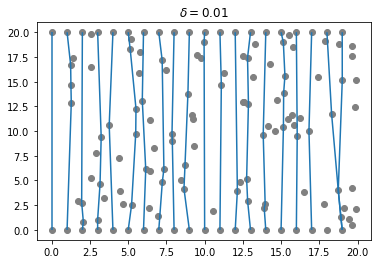

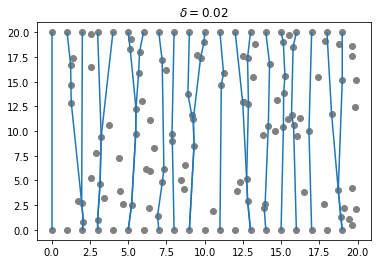

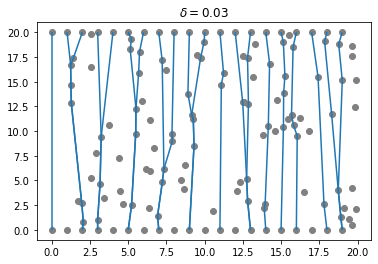

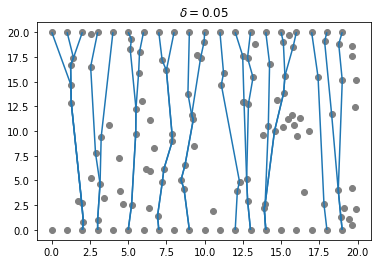

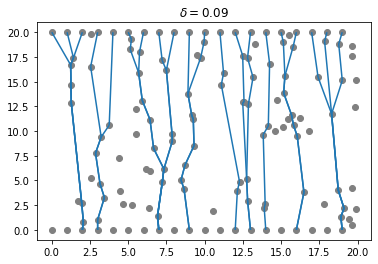

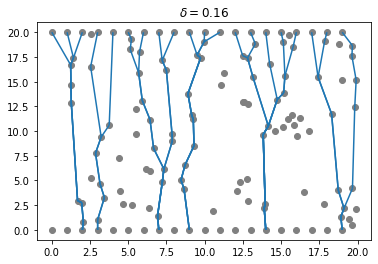

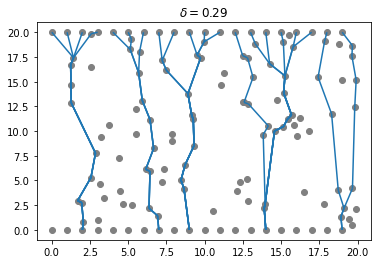

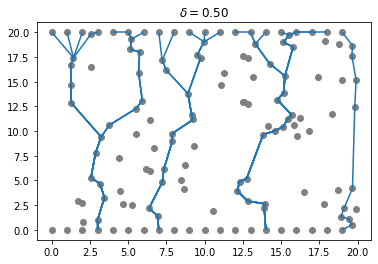

In [82]:
hs = HotspotObject(20,20,100)

for delta in np.geomspace(0.01,0.5,8):
    plt.figure()
    ax = plt.gca()
    plt.title(r'$\delta = %1.2f$' % delta)
    trees = hs.trees(delta,topnodes=hs.topidx[::])
    
    hs.plotpoints(ax)
    for tree in trees:
        hs.plottree(tree,ax)

We see that as $\delta$ is increased, the lineagies condense faster to strongly pinned paths. So this approach is consistent with the deterministic expectation of pinning.

## Wandering exponent

To characterize the wandering exponent, we vary the vertical height $l_y$ of the box and measure the MSD of a sampling of paths (somewhat arbitrarily set to intervals of $5$ length units below) as a function of $l_y$. We can calculate up to ~1000 points relatively quickly, and accumulate statistics over 20--40 independent landscapes.

We set the number of points in the landscape using a number density parameter $\rho$. 

In [3]:


def get_msds(seed,lx,ly,n,delta,spacing=5):
    hs = HotspotObject(lx,ly,n,seed)
    trees = hs.trees(delta,topnodes=hs.topidx[::spacing])
    return [hs.msd(tree) for tree in trees]

rho = 0.02
delta = 0.2

lx = 40

lys = np.geomspace(40,1000,10)
nsim = 40

msds = dict([])

for ly in lys:
    n = round(rho*lx*ly)
    print(n)
    
    task = functools.partial(get_msds,lx=lx,ly=ly,n=n,delta=delta)
    with multiprocessing.Pool(10) as pool:
        msds[ly] = pool.map(task,range(nsim))
 

32
46
65
94
134
191
274
391
559
800


In [4]:
from scipy import stats

msdave = [np.mean(msds[ly])/ly for ly in msds]
msdsem = [stats.sem(np.ravel(msds[ly]))/ly for ly in msds]

In [43]:
0.1*3.14*.2**2

0.012560000000000005

Below graph is for $\rho=0.02$ and $\delta = 0.2$. For high intensity, $\delta \approx R$ so we can think of this as a system with $\phi = \rho \pi R^2 = 0.0025$ in the strong pinning limit. We see that the lineage wandering grows as roughly $\sim l_y^{1.2}$. 

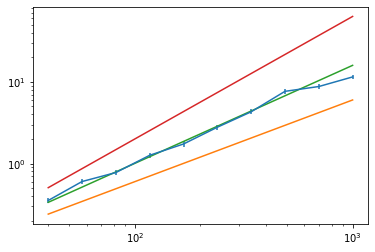

In [5]:
plt.errorbar(lys,msdave,yerr=msdsem)
plt.loglog(lys,.006*lys)
plt.loglog(lys,.004*lys**1.2)
plt.loglog(lys,.002*lys**1.5)

Now we increased $\delta$ so that we approximate $\phi = 0.01$ in strong pinning. Below we see that MSD is now consistent with $\sim l_y^{4/3}$.

In [30]:
rho = 0.02
delta = 0.4

lx = 40

lys = np.geomspace(40,1000,10)
nsim = 40

msds0p02 = dict([])

for ly in lys:
    n = round(rho*lx*ly)
    print(n)
    
    task = functools.partial(get_msds,lx=lx,ly=ly,n=n,delta=delta)
    with multiprocessing.Pool(10) as pool:
        msds0p02[ly] = pool.map(task,range(nsim))

32
46
65
94
134
191
274
391
559
800


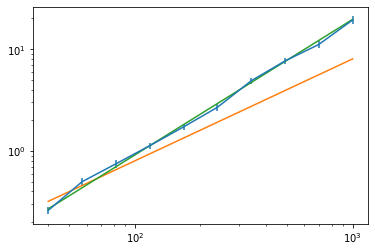

In [40]:
msdave0p02 = [np.mean(msds0p02[ly])/ly for ly in msds0p02]
msdsem0p02 = [stats.sem(np.ravel(msds0p02[ly]))/ly for ly in msds0p02]

plt.errorbar(lys,msdave,yerr=msdsem)
plt.loglog(lys,.008*lys)
plt.loglog(lys,.002*lys**1.33)


What if we have a similar $\phi$ but by increasing $\rho$ and reducing $\delta$? Below $\phi \approx 0.0125$ but now MSD is closer to diffusive than to 4/3 scaling.

In [14]:
rho = 0.1
delta = 0.2

lx = 40

lys = np.geomspace(10,400,10)
nsim = 40

msds = dict([])

for ly in lys:
    n = round(rho*lx*ly)
    print(n)
    
    task = functools.partial(get_msds,lx=lx,ly=ly,n=n,delta=delta)
    with multiprocessing.Pool(10) as pool:
        msds[ly] = pool.map(task,range(nsim))
        


40
60
91
137
206
311
468
705
1062
1600


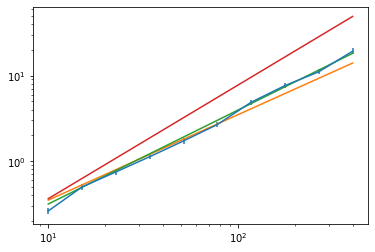

In [29]:
msdave0p1 = [np.mean(msds[ly])/ly for ly in msds]
msdsem0p1 = [stats.sem(np.ravel(msds[ly]))/ly for ly in msds]

plt.errorbar(lys,msdave,yerr=msdsem)
plt.loglog(lys,.035*lys)
plt.loglog(lys,.025*lys**1.1)
plt.loglog(lys,.017*lys**1.33)


So we find that the growth in MSD has different behavior depending on the pinning strength and area density. 

Can we see visual differences in the two situations?

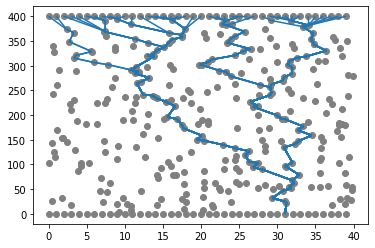

In [46]:
rho = 0.02
delta = 0.4

lx = 40

ly = 400

n = round(rho*lx*ly)

hs = HotspotObject(lx,ly,n,100)

trees = hs.trees(delta,topnodes=hs.topidx[::])
    

plt.figure()
ax = plt.gca()

hs.plotpoints(ax)
for tree in trees:
    hs.plottree(tree,ax)

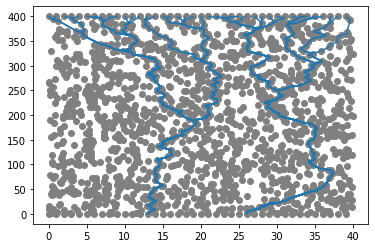

In [47]:
rho = 0.1
delta = 0.2

lx = 40

ly = 400

n = round(rho*lx*ly)

hs = HotspotObject(lx,ly,n,100)

trees = hs.trees(delta,topnodes=hs.topidx[::])

plt.figure()
ax = plt.gca()

hs.plotpoints(ax)
for tree in trees:
    hs.plottree(tree,ax)

## Proper rescaling of variables

Let's be a little less slapdash in our estimations. It is natural to use $R$ for the length units in the problem. In other words, we should report $l_x$ and $l_y$ in units of $R$. Then, as long as we set density correctly, we match the simulations by setting $\delta = 2I/(I+1)$.

To recreate the simulation parameters, where $R = 10$ and $l_x \sim 1000$ in lattice units, we should set $l_x =100$ in radius units and vary $l_y$ from $20$ to $100$. 

For Fig. 7 of the paper, we have $I = 7$. 

### Refinement for close-together hotspots

We can do better than the max qualifier above.

If $l < 2R$, we need to replace the edge weight with $$\frac{l}{v_h} = \frac{1}{v_0}\left(l \frac{v_0}{v_h}\right).$$

If we feed in a factor using the `lcut` parameter, then we can correct for this with setting the factor to be $v_0/v_h = 1/(I+1)$.

In [3]:
def get_msds(seed,lx,ly,n,delta,spacing=10,step=4,lcut=0):
    hs = HotspotObject(lx,ly,n,seed,step=step,lcut=lcut)
    trees = hs.trees(delta,topnodes=hs.topidx[::spacing])
    return [hs.msd(tree) for tree in trees]

In [ ]:
isim = 7.
nsim = 40

delta = 2*isim/(isim+1)
print("delta = ", delta)

lx = 100
lys = np.geomspace(20,100,10)

phis = [0.2,0.3,0.7]

msdphi = dict([])

for phi in phis:
    rho = phi/np.pi   # R = 1
    
    msdphi[phi] = dict([])

    for ly in lys:
        n = round(rho*lx*ly)
        print(n)

        task = functools.partial(get_msds,lx=lx,ly=ly,n=n,delta=delta,lcut=1/(isim+1.))
        with multiprocessing.Pool(10) as pool:
            msdphi[phi][ly] = pool.map(task,range(nsim))
            
    


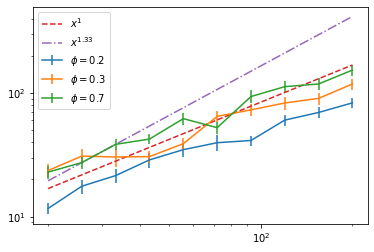

In [109]:
for phi in [0.2,0.3,0.7]:
    
    msds = msdphi[phi]
    # print(msds)
    msdave = [np.mean(msds[ly])/ly for ly in msds]
    msdsem = [stats.sem(np.ravel(msds[ly]))/ly for ly in msds]

    plt.errorbar(lys,msdave,yerr=msdsem,label=r'$\phi=%1.1f$' % phi)

plt.loglog(lys,lys*msdave[-1]/lys[-1]*1.1,'--',label=r'$x^1$')
plt.loglog(lys,lys**1.33*(msdave[1]/lys[1]**1.33),'-.',label=r'$x^{1.33}$')

plt.legend()

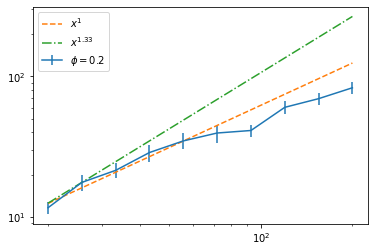

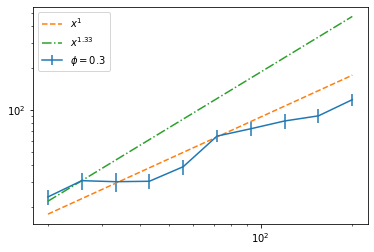

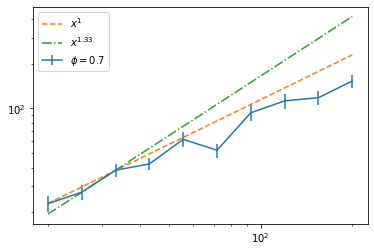

In [107]:
for phi in [0.2,0.3,0.7]:
    plt.figure()
    msds = msdphi[phi]
    # print(msds)
    msdave = [np.mean(msds[ly])/ly for ly in msds]
    msdsem = [stats.sem(np.ravel(msds[ly]))/ly for ly in msds]

    plt.errorbar(lys,msdave,yerr=msdsem,label=r'$\phi=%1.1f$' % phi)
    
    plt.loglog(lys,lys*msdave[-1]/lys[-1]*1.1,'--',label=r'$x^1$')
    plt.loglog(lys,lys**1.33*(msdave[1]/lys[1]**1.33),'-.',label=r'$x^{1.33}$')

    plt.legend()

The above results are inconclusive. We increase the number of independent reps (`nsim` variable below) and focus on low densities where we expect the assumptions of the walk to hold best.

In [5]:
isim = 7.
nsim = 200

delta = 2*isim/(isim+1)
print("delta = ", delta)

lx = 200
lys = np.geomspace(20,100,10)

phis = [0.1,0.2,0.3]

msdphilong = dict([])

for phi in phis:
    rho = phi/np.pi   # R = 1
    
    msdphilong[phi] = dict([])

    for ly in lys:
        n = round(rho*lx*ly)
        print(n)

        task = functools.partial(get_msds,lx=lx,ly=ly,n=n,delta=delta,lcut=1/(isim+1.))
        with multiprocessing.Pool(10) as pool:
            msdphilong[phi][ly] = pool.map(task,range(nsim))

delta =  1.75
255
305
364
435
521
623
745
890
1065
1273
382
457
546
653
781
934
1117
1336
1597
1910


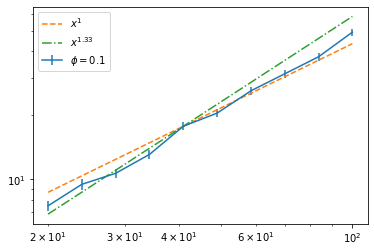

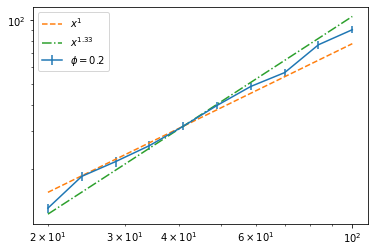

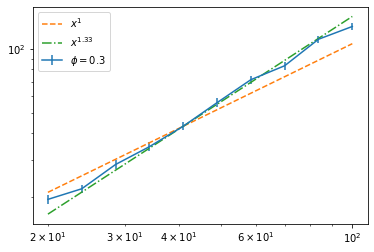

In [14]:
for phi in [0.1,0.2,0.3]:
    plt.figure()
    msds = msdphilong[phi]
    #print(msds)
    msdave = [np.mean(msds[ly])/ly for ly in msds]
    msdsem = [stats.sem(np.ravel(msds[ly]))/ly for ly in msds]

    plt.errorbar(lys,msdave,yerr=msdsem,label=r'$\phi=%1.1f$' % phi)

    plt.loglog(lys,lys*msdave[4]/lys[4],'--',label=r'$x^1$')
    plt.loglog(lys,lys**1.33*(msdave[4]/lys[4]**1.33),'-.',label=r'$x^{1.33}$')

    plt.legend()

More statistics are necessary, but there is some support for an exponent that is closer to 1 (diffusive) for lower area fractions but closer to $4/3$ (KPZ) for higher densities. It would be useful to have wider simulations to avoid issues with the finite lateral size, but the MSDs above are still small compared to (size of box)^2. 